In [1]:
import os
import numpy as np
import pandas as pd
import sklearn as sk
import scipy
from sklearn.metrics import auc, recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, plot_roc_curve, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV, SelectKBest, mutual_info_classif, chi2, f_classif
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt

### Helper functions

In [2]:
# taken from: https://scikit-learn.org/stable/modules/model_evaluation.html
def confusion_matrix_scorer(clf_, X_, y_, cell = None):
    y_pred = clf_.predict(X_)
    cm = confusion_matrix(y_, y_pred)
    cm = {'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1]}
    if cell:
        return cm[cell]
    else:
        return cm
    
def tn_scorer(clf_, X_, y_):
    return confusion_matrix_scorer(clf_, X_, y_, cell = 'tn')
def fp_scorer(clf_, X_, y_):
    return confusion_matrix_scorer(clf_, X_, y_, cell = 'fp')
def tp_scorer(clf_, X_, y_):
    return confusion_matrix_scorer(clf_, X_, y_, cell = 'tp')
def fn_scorer(clf_, X_, y_):
    return confusion_matrix_scorer(clf_, X_, y_, cell = 'fn')

def print_CV_result(cv_res, name='Model', round_dec = 4):
    print('\033[1m' + name + '\033[0m', '\t', '(mean, std, min, max)')
    print('===================================================================')
    
    longest_score_name = 0
    
    for score in cv_res.keys():
        if score == 'estimator':
            continue
        else:
            if (len(score)>longest_score_name):
                longest_score_name = len(score)
    
    for score in cv_res.keys():
        if score == 'estimator':
            continue
        else :
            arr = np.array(cv_res[score])
            print('\033[1m' + score + '\033[0m' + int(longest_score_name - len(score))*' ',
                  round(arr.mean(),round_dec),
                  round(arr.std(),round_dec), 
                  round(arr.min(),round_dec),
                  round(arr.max(),round_dec))

def print_gs_params(cv_res):
    for estimator in cv_res['estimator']:
        print ("Best parameters:")
        print(estimator.best_params_)
        print()
        print("Selected Features: ")
        print(list(X.columns[estimator.best_estimator_.named_steps['fs'].get_support()]))
        
def print_proba_score_dist(proba, y, n_bins=20, stacked=True):
    class0 = []
    class1 = []
    for cv_idx, fold in enumerate(y):
        for idx, instance in enumerate(fold):
            if instance == 0:
                class0.append(proba[cv_idx][idx, 1])
            else:
                class1.append(proba[cv_idx][idx, 1])
    
    plt.hist([class0, class1],
            bins=n_bins,
            stacked=stacked,
#                 density = True, 
#     weights = [w_0, w_1],
            label=['ADHD', 'FASD'],
            color=['cornflowerblue', 'coral'],
#                 alpha=0.7 # alpha can only be applied to both colours at once!
)
#             plt.ylim(0,1) # problem: each column needs different limits!

    plt.legend()
    plt.show()

def count_selected_features(estimator_list, feature_list):
    selected_features = {fname : 0 for fname in feature_list}

    for e in estimator_list:
        for feature in list(np.array(feature_list)[e.named_steps['fs'].get_support()]):
            selected_features[feature] += 1

    return selected_features

In [4]:
from sklearn.datasets import make_classification

X,y = make_classification(n_informative=6)

## Automatic nested Pipeline

In [6]:
scoring = {'precision_macro': sk.metrics.make_scorer(precision_score), 
           'recall_macro': sk.metrics.make_scorer(recall_score), 
           'f1_macro': sk.metrics.make_scorer(f1_score), 
           'accuracy': sk.metrics.make_scorer(accuracy_score), 
           'roc_auc': sk.metrics.make_scorer(roc_auc_score), 
           'tn': tn_scorer,
           'fp': fp_scorer,
           'tp': tp_scorer,
           'fn': fn_scorer
          }

cv_folds = 10

inner_cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=1)
outer_cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=1)

# param_grid = { 'imputer__n_neighbors' : [1, 4, 10],
#               'imputer__weights' : ['distance', 'uniform'],
#               'fs__k' : [5,6,7,8,9,10],
#               'fs__score_func' : [f_classif, mutual_info_classif],
#               'clf__C' : [2.0, 1.5, 1.0, 0.5, 0.1],
#               'clf__class_weight' : ['balanced']
#              }

param_grid = { 'imputer__n_neighbors' : [1],
              'imputer__weights' : ['distance'],
              'fs__k' : [5],
              'fs__score_func' : [f_classif, mutual_info_classif],
              'clf__C' : [1.0],
              'clf__class_weight' : ['balanced']
             }

pipe = Pipeline([('scaler', sk.preprocessing.RobustScaler()),
                 ('imputer', KNNImputer(n_neighbors=2, weights="distance")),
                 ('fs', SelectKBest(score_func=f_classif, k=5)),
                 ('clf', sk.linear_model.LogisticRegression())])


grid_search = GridSearchCV(pipe, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='roc_auc', 
                           return_train_score=True, 
                           cv=inner_cv,
                           n_jobs=-1)

res = sk.model_selection.cross_validate(grid_search, X, y, scoring=scoring, cv = outer_cv, return_estimator=True)

print_CV_result(res)

Model 	 (mean, std, min, max)
fit_time             0.3608 0.1766 0.266 0.8881
score_time           0.0056 0.0006 0.0051 0.0074
test_precision_macro 0.8583 0.1294 0.6667 1.0
test_recall_macro    0.84 0.196 0.4 1.0
test_f1_macro        0.8309 0.1395 0.5714 1.0
test_accuracy        0.84 0.12 0.7 1.0
test_roc_auc         0.84 0.12 0.7 1.0
test_tn              4.1 0.7 3 5
test_fp              0.8 0.7483 0 2
test_tp              4.3 1.1 2 6
test_fn              0.8 0.9798 0 3


# Manual nested CV-Pipeline

Model 	 (mean, std, min, max)
precision_macro 0.8598 0.1241 0.6667 1.0
recall_macro    0.82 0.1887 0.4 1.0
f1_macro        0.8195 0.1234 0.5714 1.0
accuracy        0.83 0.1005 0.7 1.0
roc_auc         0.892 0.0947 0.72 1.0


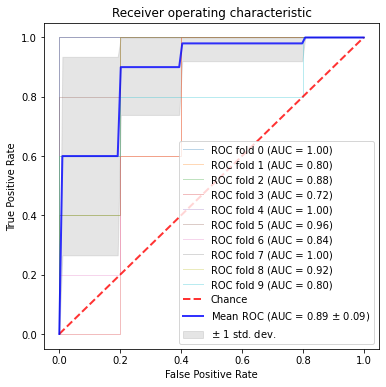

In [8]:
scoring = {'precision_macro': precision_score, 
           'recall_macro': recall_score, 
           'f1_macro': f1_score, 
           'accuracy': accuracy_score, 
           'roc_auc': roc_auc_score, 
          }

# used to optimize hyperparameters using GridSearch
score_to_optimize = 'roc_auc'
# score_to_optimize = 'f1_macro'

outer_cv_folds = 10
inner_cv_folds = 10

# param_grid = { 'imputer__n_neighbors' : [1, 4, 10],
#               'imputer__weights' : ['distance', 'uniform'],
#               'fs__k' : [5,6,7,8,9,10],
#               'fs__score_func' : [f_classif, mutual_info_classif],
#               'clf__C' : [2.0, 1.5, 1.0, 0.5, 0.1],
#               'clf__class_weight' : ['balanced']
#              }

param_grid = { 'imputer__n_neighbors' : [1],
              'imputer__weights' : ['distance'],
              'fs__k' : [5],
              'fs__score_func' : [f_classif, mutual_info_classif],
              'clf__C' : [1.0],
              'clf__class_weight' : ['balanced']
             }

#                                                                     #
# ################################################################### #
#                                                                     #

outer_cv = StratifiedKFold(n_splits=outer_cv_folds, shuffle=True, random_state=1)

results = {s : [] for s in scoring.keys()}

tprs = []
aucs = []

probas = []
y_tests = []
estimators = []

confusion_matrices = {s : [] for s in ['tn', 'tp', 'fn', 'fp']}


mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
fig.set_figheight(6)

for i, (train, test) in enumerate(outer_cv.split(X, y)):
    
    # split data
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    # configure the cross-validation procedure
    inner_cv = StratifiedKFold(n_splits=inner_cv_folds, shuffle=True, random_state=1)
    
    # define the model
    pipe = Pipeline([('scaler', sk.preprocessing.RobustScaler()),
                 ('imputer', KNNImputer(n_neighbors=2, weights="distance")),
                 ('fs', SelectKBest(score_func=f_classif, k=5)),
                 ('clf', sk.linear_model.LogisticRegression())])
    
    # define search    
    grid_search = GridSearchCV(pipe, 
                           param_grid=param_grid, 
                           scoring=score_to_optimize, 
                           refit=True, 
                           return_train_score=True, 
                           cv=inner_cv,
                           n_jobs=-1)
    
    # execute search
    search_result = grid_search.fit(X_train, y_train)
    
    # get the best performing model fit on the whole training set
    best_model = search_result.best_estimator_
    estimators.append(best_model)
    
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    yhat_proba = best_model.predict_proba(X_test)
    probas.append(yhat_proba)
    y_tests.append(y_test)
    
    # evaluate the model and store results
    
    for score in scoring:
        if score == 'roc_auc':
            results['roc_auc'].append(scoring[score](y_test, yhat_proba[:, 1]))
        else:
            results[score].append(scoring[score](y_test, yhat))
    
    cm = confusion_matrix(y_test, yhat)
    confusion_matrices['tn'].append(cm[0, 0])
    confusion_matrices['fp'].append(cm[0, 1])
    confusion_matrices['fn'].append(cm[1, 0])
    confusion_matrices['tp'].append(cm[1, 1])
        
#     acc = accuracy_score(y_test, yhat)
#     results.append(acc)
    
    # ROC curve visualization
    viz = plot_roc_curve(best_model, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
    # report progress
#     print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
    
# # summarize the estimated performance of the model
# print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

print_CV_result(results)

# Print ROC curve

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
plt.show()